In [411]:
import os
import random
import json
import numpy as np
import cv2
from PIL import Image, ImageDraw
from pycocotools import mask
from skimage import measure
import json

In [412]:
# Define the paths to the three folders containing the images
fg_folders = [
    ("Starbucks_fotos_resized/","coffee" ),
    ("/home/aldo/Documents/Test_Object_Detection/Ciel_fotos_resized/", "water"),
    ("/home/aldo/Documents/Test_Object_Detection/Cel_fotos_resized/", "cellphone"),
]
fg_folders

[('/home/aldo/Documents/Test_Object_Detection/Starbucks_fotos_resized/',
  'coffee'),
 ('/home/aldo/Documents/Test_Object_Detection/Ciel_fotos_resized/', 'water'),
 ('/home/aldo/Documents/Test_Object_Detection/Cel_fotos_resized/',
  'cellphone')]

In [413]:
# Define the path to the BackGround folder
bg_folder = "/home/aldo/Documents/Test_Object_Detection/backgrounds/"
bg_folder

'/home/aldo/Documents/Test_Object_Detection/backgrounds/'

In [414]:
#map manually the categories with their ID
annotations_ID = {
    "coffee": 0,
    "water": 1,
    "cellphone": 2
}
annotations_ID

{'coffee': 0, 'water': 1, 'cellphone': 2}

In [415]:
categories=[]

for categor in annotations_ID:
    categories.append({"id": annotations_ID[categor],"name": categor,})
categories

[{'id': 0, 'name': 'coffee'},
 {'id': 1, 'name': 'water'},
 {'id': 2, 'name': 'cellphone'}]

In [416]:
# Load the list of files in each of the three folders
fg_files = {}
for folder, category in fg_folders:
    fg_files[category] = os.listdir(folder)
fg_files

{'coffee': ['20230221_123215-transformed.png',
  '20230221_123045-transformed.png',
  '20230221_123213-transformed.png',
  '20230221_123218-transformed.png',
  '20230221_123059-transformed.png',
  '20230221_123052-transformed.png',
  '20230221_123056-transformed.png',
  '20230221_123054-transformed.png',
  '20230221_123101-transformed.png',
  '20230221_123049-transformed.png'],
 'water': ['20230221_123204-transformed.png',
  '20230221_123153-_KGTiRc-N-transformed.png',
  '20230221_123201-transformed.png',
  '20230221_123157-transformed.png',
  '20230221_123205-transformed.png',
  '20230221_123149-transformed.png',
  '20230221_123207-transformed.png',
  '20230221_123209-transformed.png',
  '20230221_123200-transformed.png'],
 'cellphone': ['20230221_123137-transformed.png',
  '20230221_123135-transformed.png',
  '20230221_123134-transformed.png',
  '20230221_123131-transformed.png']}

In [417]:
# Declare two empty list that will help as storage for the images and annotations of the dataset
images=[]
annotations=[]
#Declare in 0 the img id and annotation id
img_id=int(0)
anno_id=int(0)

In [418]:
#ATENTION The next code will ONLY generate one image, if you want to generate more images
#You neet to put the next blocks of code into a for

In [419]:
#select hramdomly how many objects will be in an image
num_objects = random.randint(0, 3)
print("number of objects",num_objects)

number of objects 3


In [420]:
# Select randomly the categories that will bve in an image
fg_categories = random.choices(["coffee", "water", "cellphone"], k=num_objects)
fg_categories

['cellphone', 'water', 'coffee']

In [421]:
# Select randomly the image for each category
fg_files_selected = []
for category in fg_categories:
    fg_files_selected.append([category,random.choice(fg_files[category])])
print("seleccion",fg_files_selected)

seleccion [['cellphone', '20230221_123134-transformed.png'], ['water', '20230221_123205-transformed.png'], ['coffee', '20230221_123045-transformed.png']]


In [422]:
# Load the selected foreground images using Pillow
fg_imgs = []
for img in fg_files_selected:
    folder = [f[0] for f in fg_folders if f[1] == img[0]][0]
    fg_imgs.append([img[0],Image.open(folder + img[1]),folder+img[1]])
fg_imgs

[['cellphone',
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=199x91 at 0x7F3CBC3AFDC0>,
  '/home/aldo/Documents/Test_Object_Detection/Cel_fotos_resized/20230221_123134-transformed.png'],
 ['water',
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=123x241 at 0x7F3CBC3AEDD0>,
  '/home/aldo/Documents/Test_Object_Detection/Ciel_fotos_resized/20230221_123205-transformed.png'],
 ['coffee',
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=132x219 at 0x7F3CBC3AE980>,
  '/home/aldo/Documents/Test_Object_Detection/Starbucks_fotos_resized/20230221_123045-transformed.png']]

In [423]:
# Randomly resize and rotate the foreground images using Pillow's transform module
for img in fg_imgs:
    fg_img=img[1]
    angle = random.randint(-45, 45)
    scale = random.uniform(0.3, 1.0)

    fg_img = fg_img.rotate(angle, resample=Image.BICUBIC, expand=True)
    fg_img = fg_img.resize((int(fg_img.width * scale), int(fg_img.height * scale)))

    img[1] = fg_img


In [424]:
#change bluur randomly
for img in fg_imgs:
    fg_img=img[1]
    blur_intensity = random.uniform(0, 1.0)*0.01
    kernel_size = (2 * round(blur_intensity * 20) + 1, 2 * round(blur_intensity * 20) + 1)
    fg_arr = np.array(fg_img)
    fg_arr = cv2.GaussianBlur(fg_arr, kernel_size, 0)
    img[1] = Image.fromarray(fg_arr)

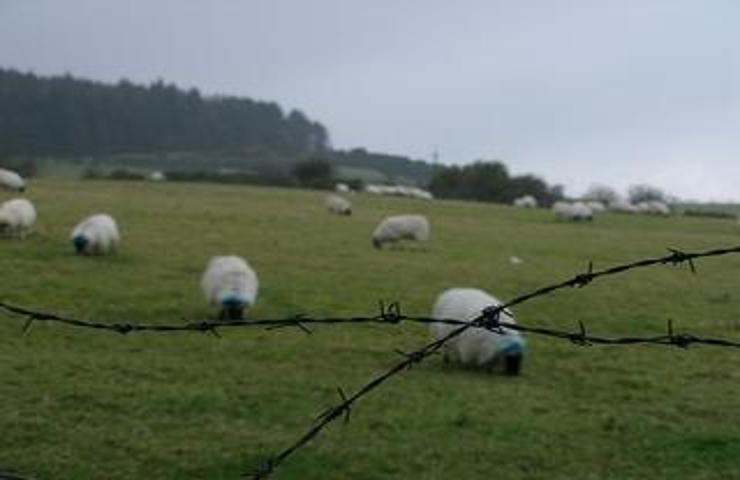

In [425]:
# Load a ramdom background image using Pillow
bg_files = os.listdir(bg_folder)
bg_file = random.choice(bg_files)
bg_img = Image.open(bg_folder + bg_file)
bg_img


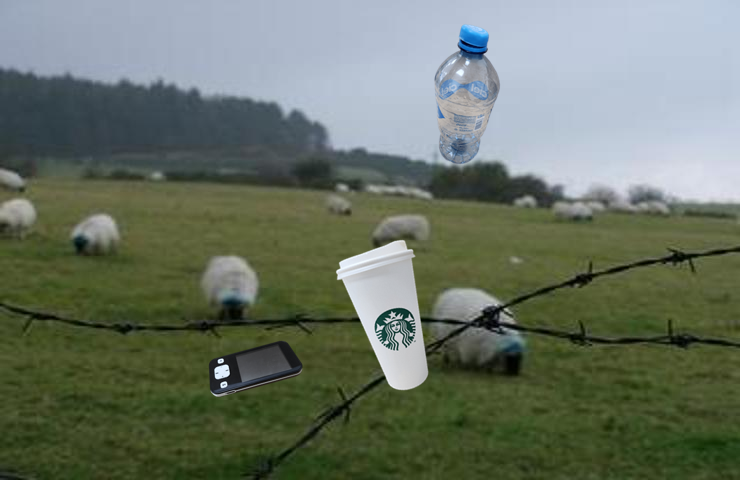

In [426]:
# Define an array to keep track of occupied areas
occupied = np.zeros((bg_img.height, bg_img.width))
for img in fg_imgs:
    fg_img=img[1]
    seg_img = img[1]

    # Define the maximum overlap as a percentage
    max_overlap_pct = 10
    
    # Calculate the maximum overlap area
    max_overlap_area = (fg_img.width * fg_img.height) * (max_overlap_pct / 100)
    
    # Convert the image to a NumPy array
    img_arr = np.array(seg_img)
    
    # Create a binary mask of the non-transparent pixels
    mask = img_arr[:, :, 3] != 0

    # Convert the mask to a COCO format segmentation
    segmentation = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                segmentation.append(j)
                segmentation.append(i)
    segmentation = [segmentation]

    # Calculate the area of the segmentation
    area = 0
    for i in range(len(segmentation[0]) // 2):
        x1 = segmentation[0][2 * i]
        y1 = segmentation[0][2 * i + 1]
        x2 = segmentation[0][(2 * i + 2) % len(segmentation[0])]
        y2 = segmentation[0][(2 * i + 3) % len(segmentation[0])]
        area += x1 * y2 - x2 * y1
    area = abs(area) / 2

    # Calculate the maximum allowed position for the top-left corner
    max_x = bg_img.width - fg_img.width
    max_y = bg_img.height - fg_img.height
    max_area = fg_img.width * fg_img.height

    # Generate a random location until an unoccupied area is found that meets the overlap limit

    for i in range (10):
        x = random.randint(0, max_x)
        y = random.randint(0, max_y)

        # Calculate the overlap area
        overlap_area = np.sum(occupied[y:y+fg_img.height, x:x+fg_img.width])

        # Check if the area is unoccupied and the overlap limit is not exceeded
        if (max_overlap_area - max_area) >= np.sum(occupied):
            break
        if i==10:
            continue
    #Update the segmentation cordinates with the position
    for i in range(0, len(segmentation[0])):
        if i % 2:
            segmentation[0][i]=int(segmentation[0][i]+y)
        else :
            segmentation[0][i]=int(segmentation[0][i]+x)
    
    # Update the occupied array
    occupied[y:y+fg_img.height, x:x+fg_img.width] = 1
    
    #paste the object in the background image
    bg_img.paste(fg_img, (x, y), fg_img)
    #add the annotation to the annotations list
    annotations.append({"id": anno_id,"image_id": img_id,"category_id": annotations_ID[img[0]],"bbox": [x, y, fg_img.width, fg_img.height],"segmentation": segmentation,"area": area,"iscrowd": 0})
    #Increment anno_id
    anno_id=anno_id+1
#Increment img_id
img_id=img_id+1
bg_img

    